In [ ]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re, string, unicodedata
import seaborn as sns
import tensorflow as tf
import pandas as pd
import json
import os
import glob
import pickle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
import warnings

# Mengabaikan semua peringatan
warnings.filterwarnings("ignore")

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input

In [ ]:
from keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, GRU, Input, Layer, LSTM, BatchNormalization, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation
from nltk.corpus import stopwords

In [ ]:
path = 'C:/Users/USER/Documents/NLP/malay/malaya_fake_news_preprocessed_dataframe.pkl'

In [ ]:
augment = 'C:/Users/USER/Documents/NLP/malay/augment_malay.csv'

In [ ]:
df_allnews_unpickled = pd.read_pickle(path)
df_allnews_unpickled

,news,tokens,rejoined,length,label,real,fake
0,demi lovato telah jujur kejam tentang pertempu...,"[demi, lovato, telah, jujur, kejam, tentang, p...",demi lovato telah jujur kejam tentang pertempu...,448,1,1,0
1,selamat pagi inilah yang perlu anda ketahui se...,"[selamat, pagi, inilah, yang, perlu, anda, ket...",selamat pagi inilah yang perlu anda ketahui se...,682,1,1,0
2,tahniah untuk bintang glee lea michele pelakon...,"[tahniah, untuk, bintang, glee, lea, michele, ...",tahniah untuk bintang glee lea michele pelakon...,247,1,1,0
3,ia adalah satu kejutan yang mengejutkan untuk ...,"[ia, adalah, satu, kejutan, yang, mengejutkan,...",ia adalah satu kejutan yang mengejutkan untuk ...,718,1,1,0
4,transkrip minggu ini dengan george stephanopou...,"[transkrip, minggu, ini, dengan, george, steph...",transkrip minggu ini dengan george stephanopou...,668,1,1,0
...,...,...,...,...,...,...,...
37587,katie holmes tidak mengandung anak jamie foxx ...,"[katie, holmes, tidak, mengandung, anak, jamie...",katie holmes tidak mengandung anak jamie foxx ...,336,0,0,1
37588,donald trump menegaskan bahawa serangan siber ...,"[donald, trump, menegaskan, bahawa, serangan, ...",donald trump menegaskan bahawa serangan siber ...,248,1,1,0
37589,ia bukan cerita pertama yang bermula dengan pe...,"[ia, bukan, cerita, pertama, yang, bermula, de...",ia bukan cerita pertama yang bermula dengan pe...,663,1,1,0
37590,presiden donald trump mengumumkan bahawa dia t...,"[presiden, donald, trump, mengumumkan, bahawa,...",presiden donald trump mengumumkan bahawa dia t...,100,1,1,0


In [ ]:
df_augment = pd.read_csv(augment)
df_augment

,translate_malay,labels
0,0 komentariev 0 foto foto ap di mana sahaja an...,1
1,"Sejak beberapa bulan lalu, hubungan antara Ame...",1
2,kami memberitahu semua orang bercakap tentang ...,1
3,"oleh peter van els, nenek moyang kadang-kadang...",1
4,"pemanggil harian 330, 000 tentera Rusia berkum...",1
...,...,...
7882,video justin bieber memandu ke rumah selena go...,1
7883,paul martin menemu bual stesen radio colorado ...,1
7884,0 menambah komen daripada taoiseach enda kenny...,1
7885,tidak ada kekurangan karya seni yang menggamba...,1


In [ ]:
df_allnews_unpickled = df_allnews_unpickled[['news','fake']]
df_allnews_unpickled = df_allnews_unpickled.rename(columns = {'news':'text', 'fake': 'labels'})
df_augment = df_augment.rename(columns = {'translate_malay':'text'})

In [ ]:
df = pd.concat([df_allnews_unpickled, df_augment])
df

,text,labels
0,demi lovato telah jujur kejam tentang pertempu...,0
1,selamat pagi inilah yang perlu anda ketahui se...,0
2,tahniah untuk bintang glee lea michele pelakon...,0
3,ia adalah satu kejutan yang mengejutkan untuk ...,0
4,transkrip minggu ini dengan george stephanopou...,0
...,...,...
7882,video justin bieber memandu ke rumah selena go...,1
7883,paul martin menemu bual stesen radio colorado ...,1
7884,0 menambah komen daripada taoiseach enda kenny...,1
7885,tidak ada kekurangan karya seni yang menggamba...,1


In [ ]:
df['labels'].value_counts()

labels
0    25030
1    20449
Name: count, dtype: int64

In [ ]:
df.isna().sum()

text      0
labels    0
dtype: int64

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['num_char'] = df['text'].apply(lambda x: len(x))
df.head()

,text,labels,word_count,num_char
0,demi lovato telah jujur kejam tentang pertempu...,0,463,2941
1,selamat pagi inilah yang perlu anda ketahui se...,0,704,4878
2,tahniah untuk bintang glee lea michele pelakon...,0,244,1540
3,ia adalah satu kejutan yang mengejutkan untuk ...,0,757,5144
4,transkrip minggu ini dengan george stephanopou...,0,706,4736


# Data Filtering

In [ ]:
df_pre_new = df.loc[(df['word_count'] >= 5) & (df['word_count'] < 500)]
df_pre_new

,text,labels,word_count,num_char
0,demi lovato telah jujur kejam tentang pertempu...,0,463,2941
2,tahniah untuk bintang glee lea michele pelakon...,0,244,1540
6,0 komentariev 0 foto foto ap di mana sahaja an...,1,448,2761
9,meghan markle semakin meningkat di pangkat bri...,0,40,278
10,"sejak beberapa bulan yang lalu , hubungan anta...",1,343,2471
...,...,...,...,...
7882,video justin bieber memandu ke rumah selena go...,1,34,226
7883,paul martin menemu bual stesen radio colorado ...,1,68,467
7884,0 menambah komen daripada taoiseach enda kenny...,1,415,2929
7885,tidak ada kekurangan karya seni yang menggamba...,1,29,206


In [ ]:
df_pre_new['labels'].value_counts()

labels
1    15765
0    13728
Name: count, dtype: int64

In [ ]:
MAX_LEN = 400
SEED = 80

In [ ]:
df = df_pre_new[['text', 'labels']]

In [ ]:
df = df.sample(frac = 1, ignore_index=True, random_state=SEED)
df

,text,labels
0,bintang jedi terakhir digugurkan oleh pertunju...,0
1,guru tidak pasti akan membelasah kelapan malam...,1
2,video muzik rasmi untuk perangkap oleh shakira...,0
3,obshchestvo v seti berkala ukolchik protiv gri...,1
4,tonton bahaya suami biden bahaya untuk bukit d...,1
...,...,...
29488,buat jalan untuk pic georgia baru eva marcille...,0
29489,"halaman lisa , bekas peguam fbi di bawah james...",1
29490,sukan gambar foto ini menunjukkan ahli pasukan...,1
29491,brad pitt baru baru ini dikhabarkan untuk memu...,1


# Text Preprocessing

In [ ]:
df.iloc[19000,0]

'surat harian pasangan yang baru berkahwin telah mendakwa hari besar mereka hancur apabila seorang lelaki meletup di dalam gereja yang menjerit allahu akbar dan kemudian mula merobohkan hiasan perkahwinan pengantin lelaki marcel lohbeck , 35 , dan pengantin perempuan yang merayakannya merayakan perkahwinan mereka dengan 90 tetamu di gereja karmel di duisburg , sebuah bandar di jerman barat lochbeck berkata pada permulaan majlis itu , seorang lelaki dengan pelompat tebal dan topi masuk ke gereja dan duduk di barisan belakang tidak lama kemudian , dia berdiri dan berjalan jalan mengelilingi lilin dia tertawa dengan cara yang mengganggu dan kemudian melepaskan patung mary dia telah bercakap dalam bahasa arab dan sebahagian inggeris dia kemudiannya memusnahkan bunga dan terus menjerit allahu akbar pegawai polis ludger a , 57 , bapa saudara lelaki itu , dilaporkan cuba campur tangan bersama dengan sexton gereja pegawai itu berkata kami cuba menenangkan lelaki syria yang sangat trauma selepa

In [ ]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |   

True

In [ ]:
# import nltk
# nltk.download('punkt')

# from nltk.tokenize import word_tokenize
# import re
# import unicodedata

# # Fungsi untuk memuat stopwords dari file lokal
# def load_stopwords_from_file(filepath):
#     with open(filepath, 'r', encoding='utf-8') as file:
#         stopwords_malay = file.read().splitlines()
#     return set(stopwords_malay)

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import re
import unicodedata
from nltk.tokenize import word_tokenize

# Fungsi untuk memuat stopwords dari file lokal
def load_stopwords_from_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        stopwords_malay = file.read().splitlines()
    return set(stopwords_malay)

# Fungsi untuk membersihkan teks
def cleaning(text,stopwords_file_path='C:/Users/USER/Documents/NLP/malay/malaysian.txt'):
    # Menghapus karakter non-ascii
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Menghapus URL
    text = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

    # Menghapus tanda baca
    text = re.sub(r'[^\w\s]|_', ' ', text)

    # Menghapus kata yang mengandung angka
    text = re.sub(r'\S*\d\S*', '', text).strip()

    # Menghapus angka yang terisolasi
    text = re.sub(r'\b\d+\b', '', text)

    # Mengonversi menjadi huruf kecil
    text = text.lower()

    # Menghapus spasi tambahan
    text = re.sub(r'\s+', ' ', text).strip()

    # Mengganti kata tertentu (tambahkan sesuai kebutuhan)
    text = text.replace("yg", "yang")

    # Memuat stopwords dari file lokal
    stopwords_malay = load_stopwords_from_file(stopwords_file_path)

    # Menghapus stopwords dari teks
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in stopwords_malay])

    return text

In [ ]:
# Path ke file stopwords Bahasa Melayu
stopwords_file_path = 'C:/Users/USER/Documents/NLP/malay/malaysian.txt'

In [ ]:
print(load_stopwords_from_file(stopwords_file_path))

{'dahulu', 'sambil', 'engkaulah', 'bilakah', 'setelah', 'selama', 'menyebabkan', 'mengapakah', 'sebelumnya', 'adanya', 'sekitar', 'daripadaku', 'hai', 'secara', 'seraya', 'katakan', 'sebanyak', 'tanyakanlah', 'bahawasanya', 'antara', 'hanya', 'walaupun', 'memang', 'banyaknya', 'adalah', 'dapatlah', 'agar', 'apa', 'apa-apa', 'ya', 'oleh', 'akan', 'dapat', 'agak', 'atasnya', 'setiap', 'ku', 'iaitu', 'seluruhnya', 'para', 'sana', 'pergilah', 'selalu', 'separuh', 'atas', 'engkaukah', 'siapa', 'kembali', 'aku', 'itukah', 'sini', 'sudah', 'walau', 'padanya', 'dimanakah', 'merekapun', 'bukanlah', 'mendapati', 'sementara', 'sebab', 'sama-sama', 'tiap-tiap', 'sebagai', 'sesuatu', 'terhadapmu', 'kerananya', 'antaranya', 'inilah', 'sentiasa', 'boleh', 'semula', 'hendaklah', 'langsung', 'akupun', 'masih', 'masing-masing', 'senantiasa', 'bagaimana', 'sesudah', 'sejak', 'saya', 'kita', 'sampai', 'sedangkan', 'ia', 'al', 'bila', 'dan', 'seseorang', 'mendapatkan', 'berupa', 'yang', 'begitupun', 'hingg

In [ ]:
# # Menerapkan fungsi cleaning
# df['text'] = df['text'].apply(lambda x: cleaning(x, stopwords_file_path))

In [ ]:
df['text'] = df['text'].apply(cleaning)

In [ ]:
df.iloc[19000,0]

'surat harian pasangan baru berkahwin mendakwa hari besar hancur seorang lelaki meletup gereja menjerit allahu akbar mula merobohkan hiasan perkahwinan pengantin lelaki marcel lohbeck pengantin perempuan merayakannya merayakan perkahwinan tetamu gereja karmel duisburg sebuah bandar jerman barat lochbeck berkata permulaan majlis seorang lelaki pelompat tebal topi masuk gereja duduk barisan belakang lama berdiri berjalan jalan mengelilingi lilin tertawa cara mengganggu melepaskan patung mary bercakap bahasa arab sebahagian inggeris kemudiannya memusnahkan bunga terus menjerit allahu akbar pegawai polis ludger a bapa saudara lelaki dilaporkan cuba campur tangan bersama sexton gereja pegawai berkata cuba menenangkan lelaki syria trauma selepas lelaki tersebut enggan meninggalkan gereja pergaduhan pegawai polis kecederaan ringan wajahnya namun berjaya menahan lelaki rakan rakannya polis duisburg tiba selepas pemeriksaan perubatan lelaki berusia tahun dibawa hospital psikiatri'

labels
1    15765
0    13728
Name: count, dtype: int64


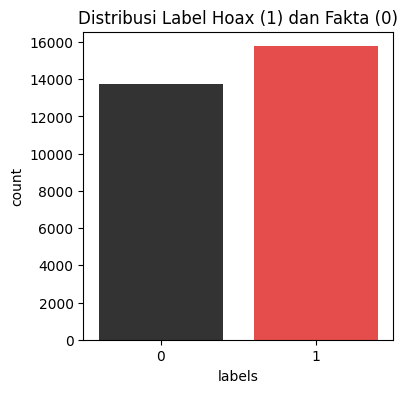

In [ ]:
print(df['labels'].value_counts())
plt.figure(figsize=(4, 4))
sns.countplot(x='labels', palette={'0': 'black', '1': 'red'}, alpha=0.8, data=df)
plt.title('Distribusi Label Hoax (1) dan Fakta (0)')
plt.show()

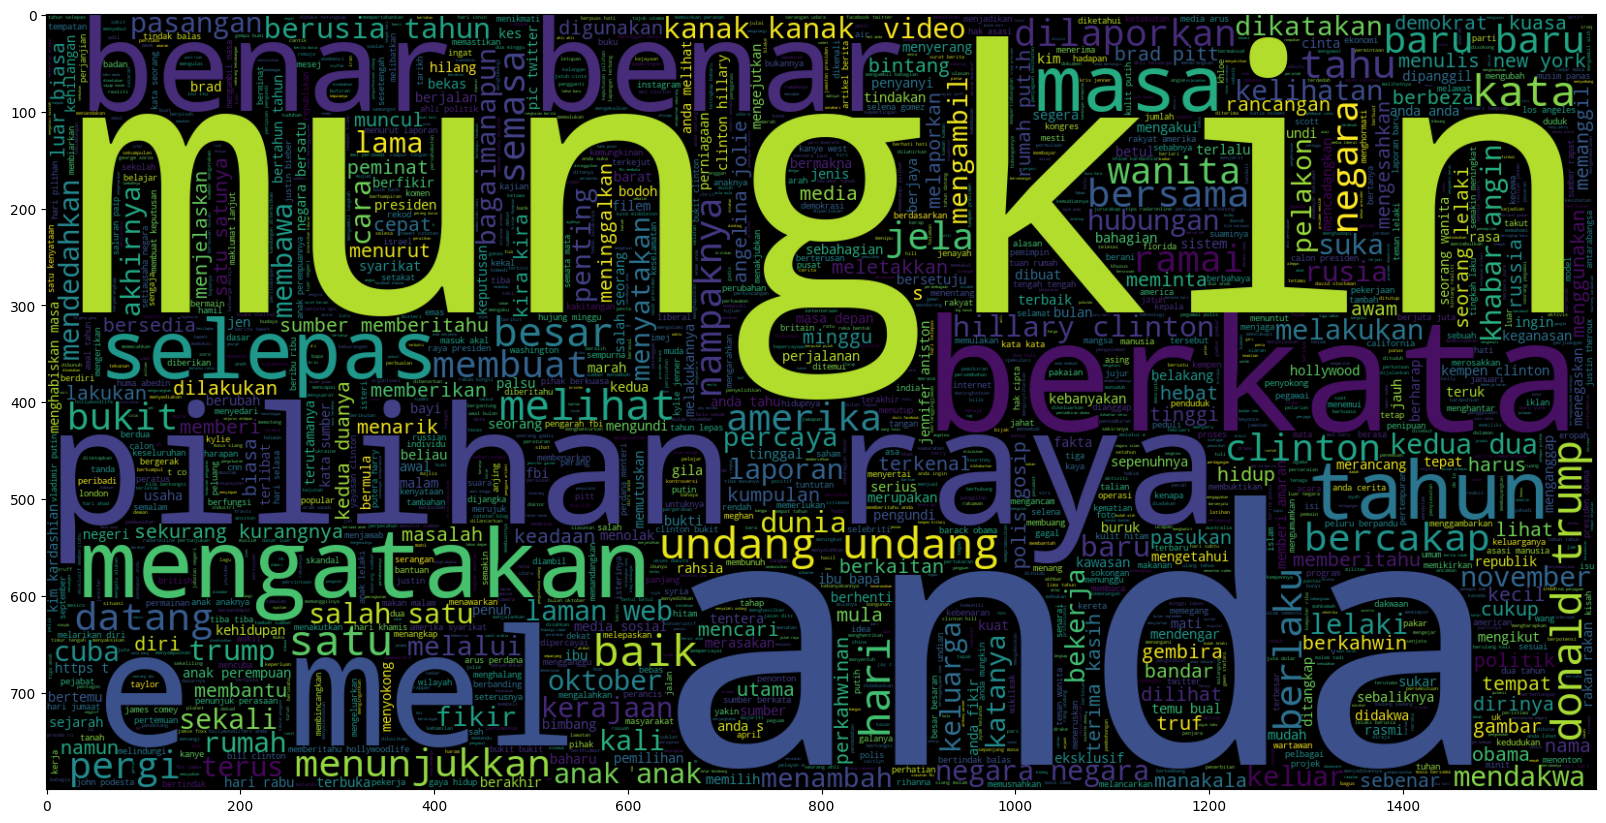

In [ ]:
from wordcloud import WordCloud,STOPWORDS
# label 1 untuk hoax
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.labels == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

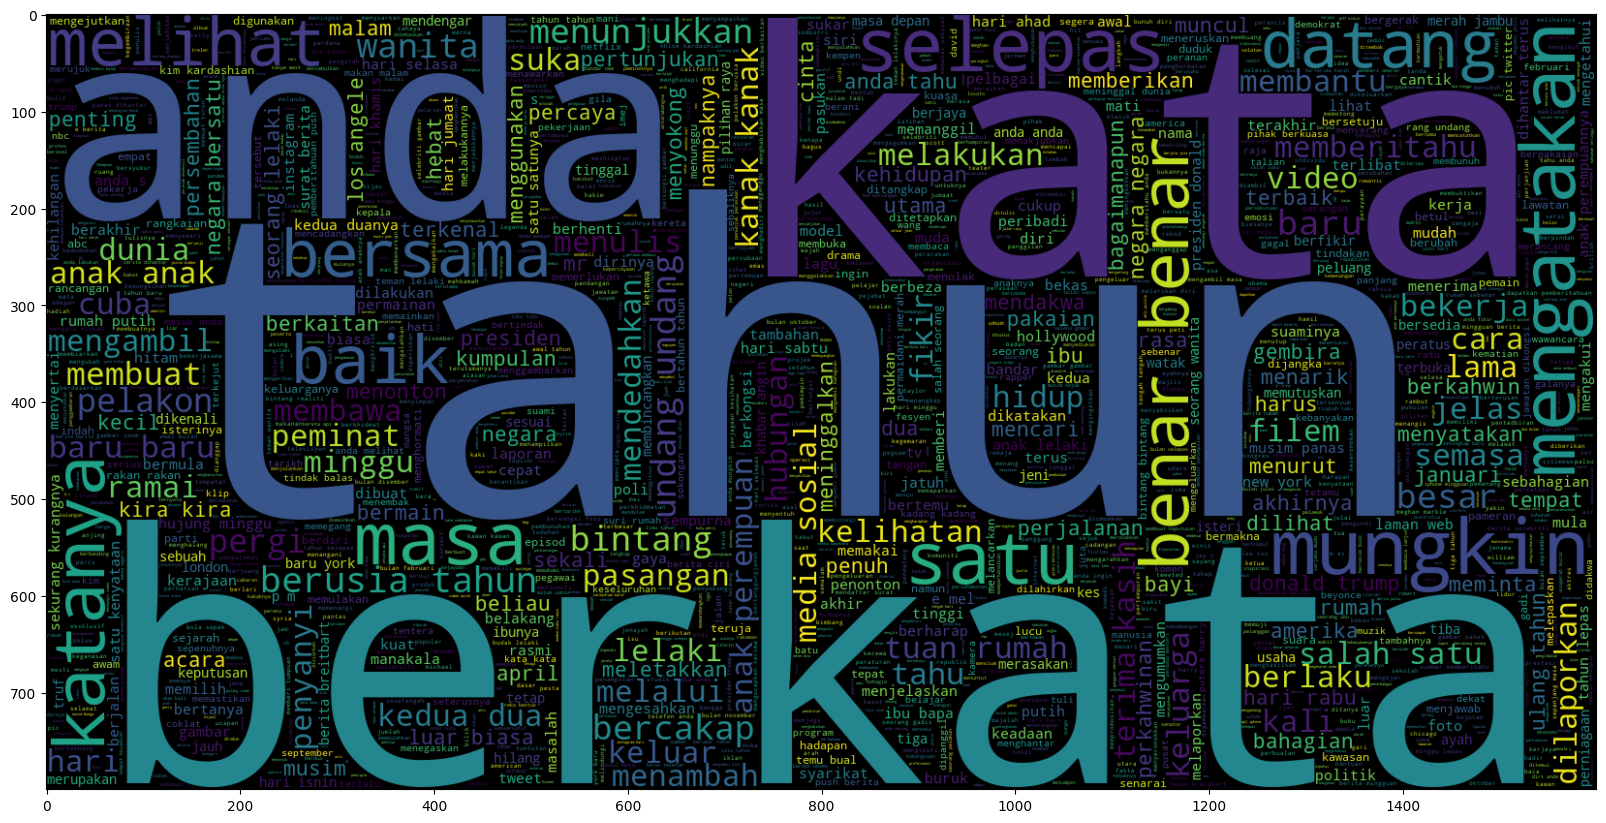

In [ ]:
# label 0 untuk valid
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.labels == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# Data Splitting

In [ ]:
X = df['text']
y = df['labels']

In [ ]:
#split the train and test data
from sklearn.model_selection import train_test_split

In [ ]:
#split the train and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state=42)

# Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
tokenizer.word_index

{'anda': 1,
 'tahun': 2,
 'hari': 3,
 'baru': 4,
 'satu': 5,
 'anak': 6,
 'masa': 7,
 'selepas': 8,
 'seorang': 9,
 'negara': 10,
 'kata': 11,
 'benar': 12,
 'berkata': 13,
 'berita': 14,
 'mungkin': 15,
 'baik': 16,
 'dua': 17,
 'rumah': 18,
 'presiden': 19,
 'undang': 20,
 'lelaki': 21,
 'trump': 22,
 'clinton': 23,
 'melihat': 24,
 'membuat': 25,
 'bersama': 26,
 'bulan': 27,
 'bintang': 28,
 'besar': 29,
 'memberitahu': 30,
 'tahu': 31,
 'wanita': 32,
 'sumber': 33,
 'malam': 34,
 'mengatakan': 35,
 'minggu': 36,
 'mengambil': 37,
 'semasa': 38,
 'dunia': 39,
 'kedua': 40,
 'gambar': 41,
 'datang': 42,
 'video': 43,
 'e': 44,
 'amerika': 45,
 'twitter': 46,
 'melakukan': 47,
 'pilihan': 48,
 'musim': 49,
 'ibu': 50,
 'berlaku': 51,
 'pelakon': 52,
 'menunjukkan': 53,
 'salah': 54,
 'com': 55,
 'katanya': 56,
 'kanak': 57,
 'pasangan': 58,
 'keluarga': 59,
 'pergi': 60,
 'memberi': 61,
 'kali': 62,
 'bercakap': 63,
 'laporan': 64,
 'media': 65,
 'raya': 66,
 'filem': 67,
 'diri': 68

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df

,text,labels,word_count
0,bintang jedi terakhir digugurkan pertunjukan m...,0,192
1,guru membelasah kelapan malam berjalan seorang...,1,103
2,video muzik rasmi perangkap shakira maluma bai...,0,31
3,obshchestvo v seti berkala ukolchik protiv gri...,1,322
4,tonton bahaya suami biden bahaya bukit reaksi ...,1,36
...,...,...,...
29488,buat jalan pic georgia baru eva marcille menye...,0,170
29489,halaman lisa bekas peguam fbi james comey andr...,1,259
29490,sukan gambar foto menunjukkan ahli pasukan ber...,1,92
29491,brad pitt baru baru dikhabarkan memukul marbie...,1,175


In [ ]:
# Menampilkan jumlah kata maksimum dalam kolom 'word_count'
max_word_count = df['word_count'].max()
print("Jumlah kata maksimum dalam kolom 'word_count':", max_word_count)

max_index = df['word_count'].idxmax()
print("Pada kolom 'word_count' indeks ke:", max_index)

Jumlah kata maksimum dalam kolom 'word_count': 399
Pada kolom 'word_count' indeks ke: 11628


In [ ]:
padding_type = 'post'
truncating_type = 'post'

def get_sequences(tokenizer, text):
  sequences = tokenizer.texts_to_sequences(text)
  padded_sequences = pad_sequences(sequences, truncating='post', maxlen=MAX_LEN, padding='post')
  return padded_sequences

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  102533


In [ ]:
padded_train_sequences = get_sequences(tokenizer, X)
print(padded_train_sequences[6583])

[  364    71   194   899  1221   559   364    71    46   899  1221   559
  3193  4611  7033    60  2440    17    36     8 32674  4611  7033   201
    17    36     8 32674  4611   732  2190    17    36     8  1130  1793
  2347   156 20532    33    13  3193  4611  2584    17    36     8    46
 20532   107  4002   973   703  1871 49956   311    16    16   773  4611
    60   315  2327   247    30   935    55   140  1793  1632  1413  1314
   732  4360  2508    95   781   994  1267 19812  2508     8   530   590
  9984   291  3308    19    80    22  1296   435   811   590   134   777
    93   587   855  4104    76  4611  1285   346    44    70   303   755
    93  7029   781   188   247  3193  3305  2288  3023   120    13  1103
    93   606    59   346    44    70  2382  2500   251  4360    60 49957
   775  9469  1116    27     4     4   311   489     8   311  5468    78
    28   269    82     2     2   958   581 13412   163 17789  3446 10293
 10703    54     9  1026   115  1207   133  3743 15

In [ ]:
classes = set(y)
classes_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_classes = dict((v,k) for k, v in classes_to_index.items())
names_to_ids_training = lambda labels: np.array([classes_to_index.get(X) for X in y])
labels = names_to_ids_training(y)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [ ]:
labels = label_encoder.transform(labels)

In [ ]:
labels

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

# Sequence and padding

In [ ]:
# untuk data train
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = MAX_LEN,
                                padding = padding_type,
                                truncating = truncating_type)

In [ ]:
# untuk data validation
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences,
                                maxlen = MAX_LEN,
                                padding = padding_type,
                                truncating = truncating_type)

In [ ]:
# untuk data test
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = MAX_LEN,
                               padding = padding_type,
                               truncating = truncating_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of val tensor: ', val_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (23594, 400)
Shape of val tensor:  (2949, 400)
Shape of testing tensor:  (2950, 400)


In [ ]:
# Convert the labels lists into numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test =np.array(y_test)

In [ ]:
print('Shape of training tensor: ', y_train.shape)
print('Shape of val tensor: ', y_val.shape)
print('Shape of testing tensor: ', y_test.shape)

Shape of training tensor:  (23594,)
Shape of val tensor:  (2949,)
Shape of testing tensor:  (2950,)


# Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, SpatialDropout1D, Dropout, Dense
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling1D
from tensorflow.keras import models
from tensorflow.keras.regularizers import l2

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Hyperparameters
embedding_dim = 50
MAX_LEN = 400
drop_lstm = 0.5
l2_reg = 5e-3
drop_embed = 0.5

# Input Layer
input_layer = layers.Input(shape=(MAX_LEN,))

# Embedding Layer
embedding_layer = layers.Embedding(vocab_size, embedding_dim, input_length=MAX_LEN)(input_layer)

# Spatial Dropout Layer
spatial_dropout = layers.SpatialDropout1D(rate=drop_embed)(embedding_layer)

# Bi-LSTM Layers with Dropout
lstm1 = layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=drop_lstm))(spatial_dropout)
dropout1 = layers.Dropout(drop_lstm)(lstm1)
lstm2 = layers.Bidirectional(layers.LSTM(16, return_sequences=True, dropout=drop_lstm))(dropout1)
dropout2 = layers.Dropout(drop_lstm)(lstm2)

# Transformer Block
transformer_block = TransformerBlock(embed_dim=32, num_heads=2, ff_dim=64, rate=drop_lstm)
transformer_output = transformer_block(dropout2)
global_average_pooling = layers.GlobalAveragePooling1D()(transformer_output)

# Dense Layer with Dropout
# dense1 = layers.Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))(global_average_pooling)
# dropout2 = layers.Dropout(drop_lstm)(dense1)
dense2 = layers.Dense(16, activation='relu', kernel_regularizer=l2(l2_reg))(global_average_pooling)
dropout3 = layers.Dropout(drop_lstm)(dense2)

# Output Layer
output_layer = layers.Dense(1, activation='sigmoid')(dropout3)

# Build Model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 400, 50)        │     5,126,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 400, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400, 64)        │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 400, 32)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 400, 32)        │        12,736 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,171,547 (19.73 MB)

 Trainable params: 5,171,547 (19.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

hreshold = 0.5

# Define metrics
def recall_m(y_true, pred):
    y_true = K.cast(y_true, 'float32')
    pred = K.cast(K.greater(pred, threshold), 'float32')  # Apply threshold
    true_positives = K.sum(K.round(K.clip(y_true * pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, pred):
    y_true = K.cast(y_true, 'float32')
    pred = K.cast(K.greater(pred, threshold), 'float32')  # Apply threshold
    true_positives = K.sum(K.round(K.clip(y_true * pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, pred):
    precision = precision_m(y_true, pred)
    recall = recall_m(y_true, pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def rmse(y_true, pred):
    y_true = K.cast(y_true, 'float32')
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, pred)))

def dice_coef(y_true, pred):
    y_true = K.cast(y_true, 'float32')
    y_true_f = K.flatten(y_true)
    pred_f = K.flatten(pred)
    intersection = K.sum(y_true_f * pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(pred_f) + 1)

In [ ]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=3.1250e-06),
              loss='binary_crossentropy',
              metrics=['accuracy', recall_m, precision_m, f1_m, dice_coef, rmse])

In [ ]:
# Callbacks
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Fit model
num_epochs = 100
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    batch_size=32,
                    validation_data=(val_padded, y_val),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100


ValueError: Expected all entries in the `metrics` list to be metric objects. Received instead:
metrics=['accuracy', 17.0, 16.344085693359375, 16.617969512939453, 0.9041301012039185, 0.6718971133232117]

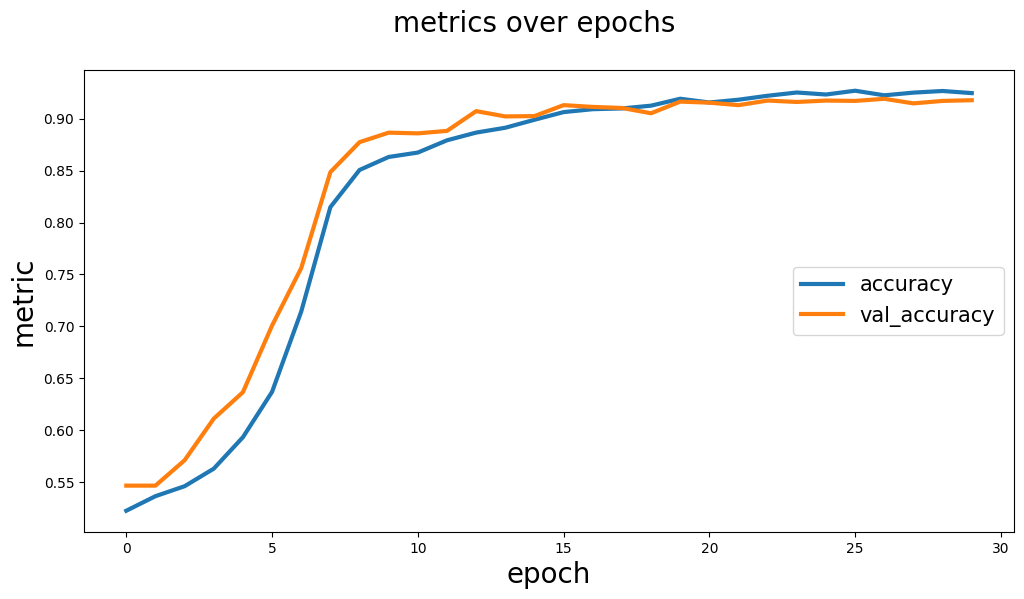

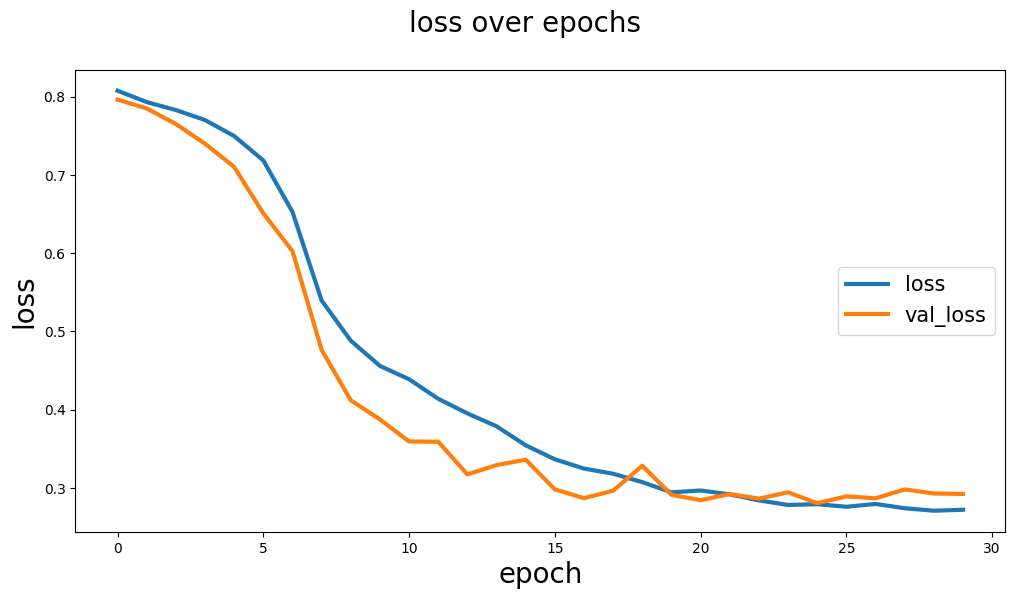

In [ ]:
#!pip install keras-unet
from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['accuracy', 'val_accuracy'],
    losses=['loss', 'val_loss']
)

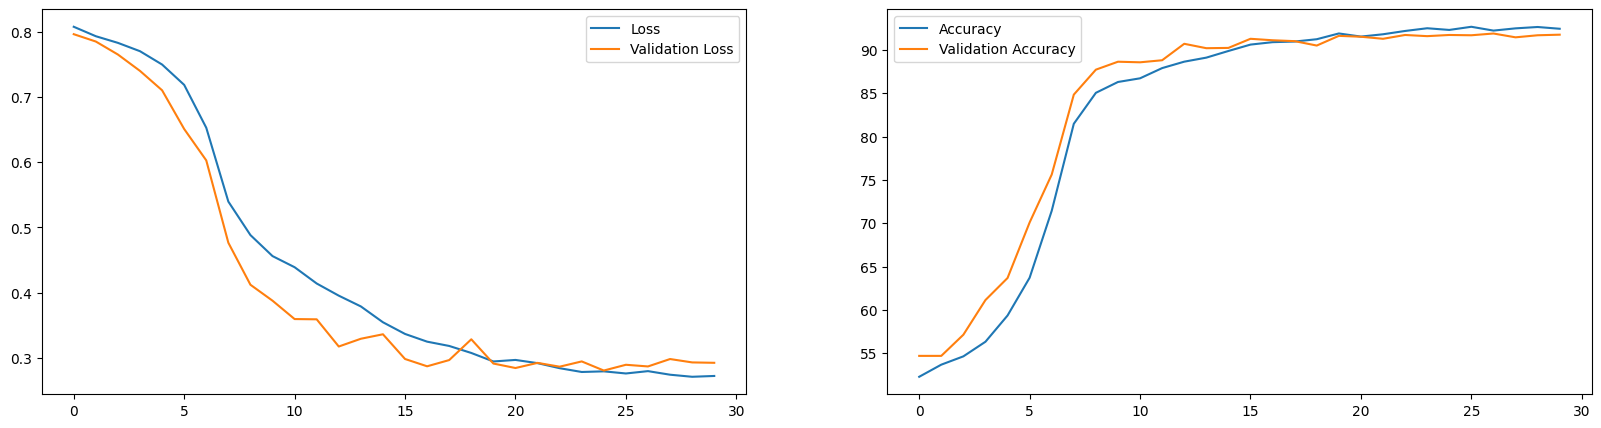

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(history.history['accuracy']), '-',
         label = 'Accuracy')
ax2.plot(100*np.array(history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

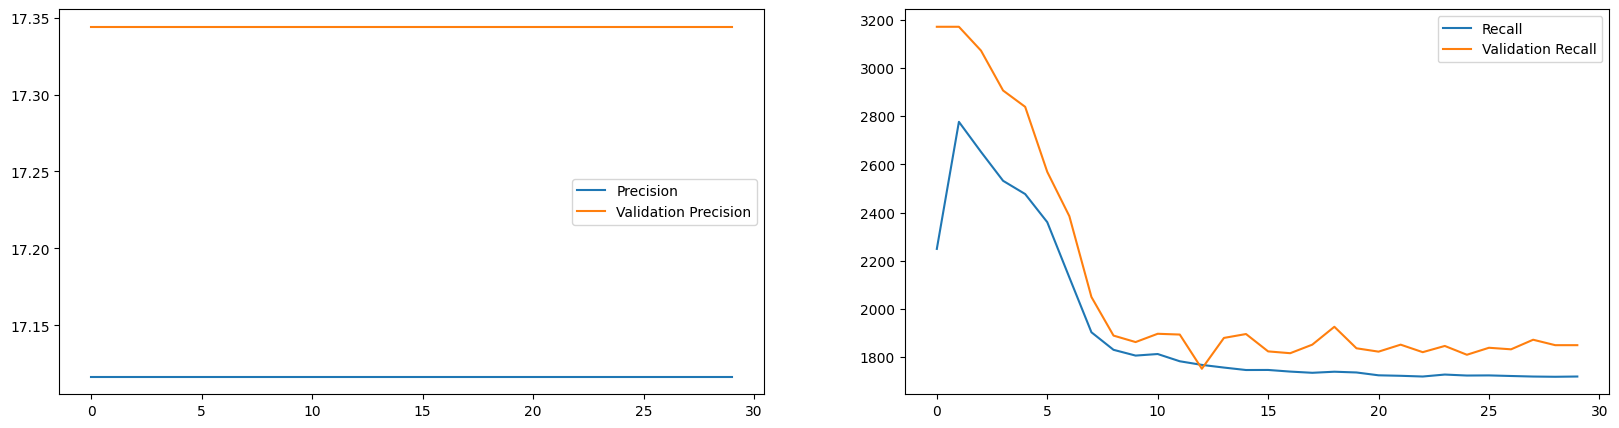

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
ax1.plot(history.history['precision_m'], '-', label = 'Precision')
ax1.plot(history.history['val_precision_m'], '-', label = 'Validation Precision')
ax1.legend()

ax2.plot(100*np.array(history.history['recall_m']), '-',
         label = 'Recall')
ax2.plot(100*np.array(history.history['val_recall_m']), '-',
         label = 'Validation Recall')
ax2.legend()

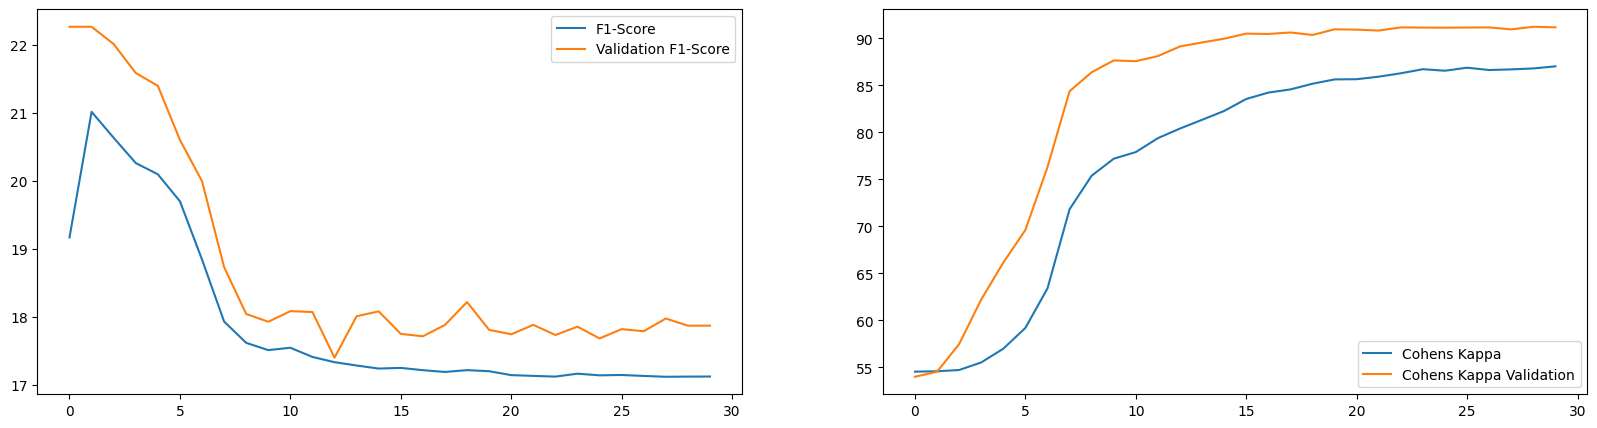

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
ax1.plot(history.history['f1_m'], '-', label = 'F1-Score')
ax1.plot(history.history['val_f1_m'], '-', label = 'Validation F1-Score')
ax1.legend()

ax2.plot(100*np.array(history.history['dice_coef']), '-', label = 'Cohens Kappa')
ax2.plot(100*np.array(history.history['val_dice_coef']), label = 'Cohens Kappa Validation')
ax2.legend()

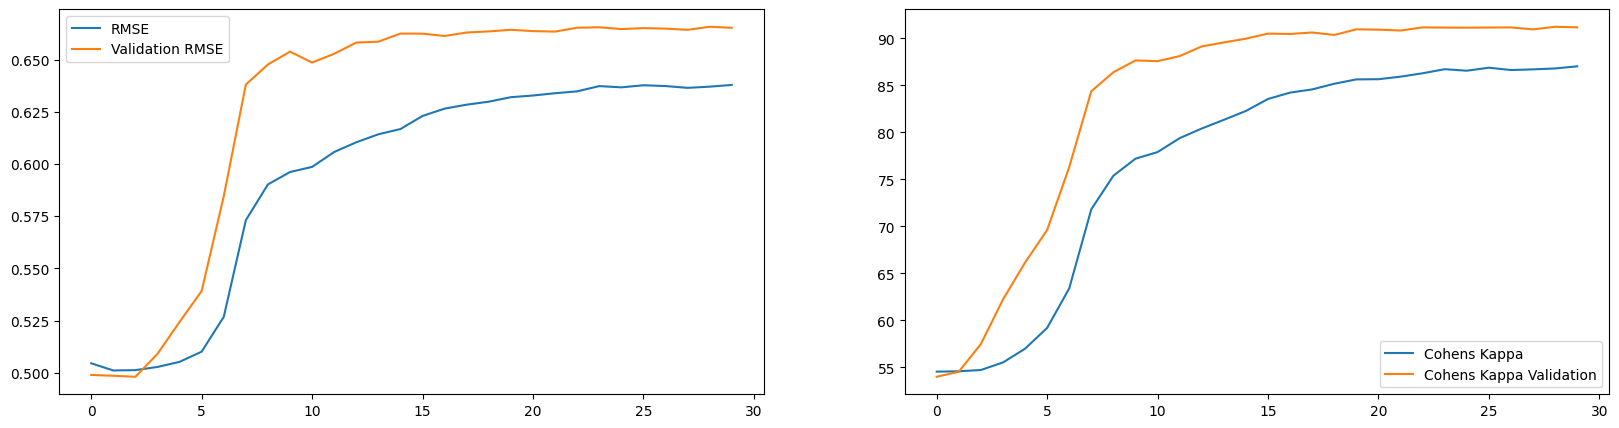

In [ ]:
# fig, (ax1) = plt.subplots(1, 2, figsize = (20, 5))
# ax1.plot(history.history['rmse'], '-', label = 'RMSE')
# ax1.plot(history.history['val_rmse'], '-', label = 'Validation RMSE')
# ax1.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))  # Dua subplot, jadi unpacking (ax1, ax2)
ax1.plot(history.history['rmse'], '-', label='RMSE')
ax1.plot(history.history['val_rmse'], '-', label='Validation RMSE')
ax1.legend()

ax2.plot(100*np.array(history.history['dice_coef']), '-', label='Cohens Kappa')
ax2.plot(100*np.array(history.history['val_dice_coef']), label = 'Cohens Kappa Validation')
ax2.legend()
plt.show()

In [ ]:
loss,accuracy, recall_m, precision_m, f1_m, dice_coef, rmse = model.evaluate(testing_padded, y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9127 - dice_coef: 0.9045 - f1_m: 16.8478 - loss: 0.2968 - precision_m: 16.7281 - recall_m: 17.0456 - rmse: 0.6719


In [ ]:
accuracy

0.9128813743591309

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step


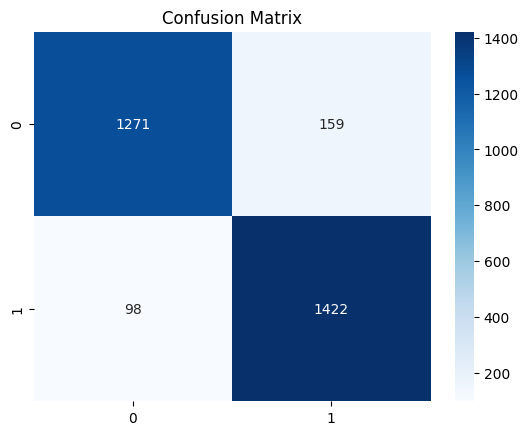

In [ ]:
threshold = 0.5
y_pred = (model.predict(testing_padded) > threshold).astype("int32")
cnf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cnf_matrix,annot=True,cmap="Blues",fmt=".5g")
plt.title("Confusion Matrix");

In [ ]:
y_predict = (model.predict(testing_padded) > threshold).astype("int32")
y_predict_label=np.argmax(y_predict,axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


In [ ]:
# Print the classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1430
           1       0.90      0.94      0.92      1520

    accuracy                           0.91      2950
   macro avg       0.91      0.91      0.91      2950
weighted avg       0.91      0.91      0.91      2950



93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


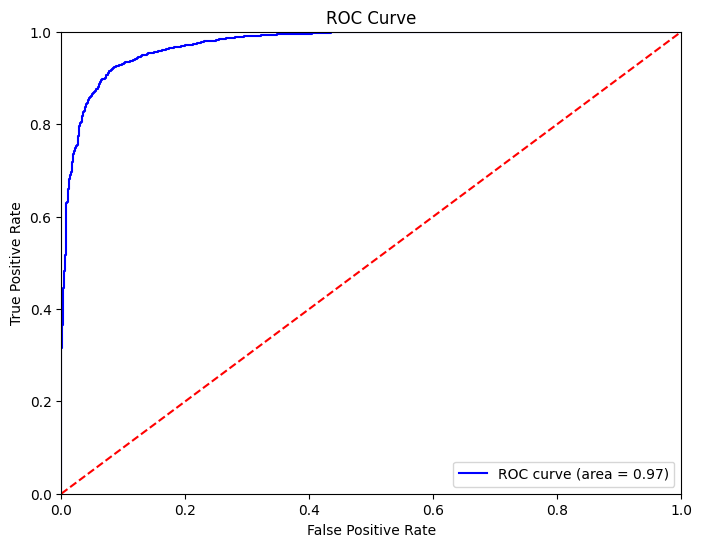

In [ ]:
from sklearn.metrics import roc_curve, auc

# Menghitung probabilitas prediksi
y_pred_prob = model.predict(testing_padded).ravel()

# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Menghitung AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Menyimpan model ke direktori spesifik
model.save('C:/Users/USER/Documents/NLP/malay/zzzz/model_malay_biLSTM_transformer1.hdf5')

In [ ]:
import pandas as pd
# Menggunakan 'history' dari hasil model.fit
hist_df = pd.DataFrame(history.history)

# Jika ingin menyimpan riwayat ke file CSV
hist_df.to_csv('C:/Users/USER/Documents/NLP/malay/zzzz/malay_training_history1.csv')